1. 以下关于双线性模型的说法，不正确的是：    
   A. 双线性模型考虑了特征之间的关联，比线性模型建模能力更强。   
   B. 在因子分解机中，因为引入了特征的乘积，只有特征$x_i$与$x_j$都不为零时才能更新参数$w_{ij}$。   
   C. 可以通过重新设置参数，把因子分解机中的常数项和一次项都合并到二次项里，得到更一般的表达式。   
   D. 在矩阵分解中，最优的特征数量$d$是超参数，不能通过公式推导出来。  

答：  
A. 正确。双线性模型考虑了特征之间的相互作用，线性模型中每个特征都是独立的。双线性模型能对更加复杂的场景进行建模，也可以通过设置参数退化导线性模型，比线性模型的建模能力是更强的。  
B. 错误。更新参数$w_{ij}$不严格要求特征不为零，因子分解机处理稀疏矩阵时候某些特征就是为零的，可以通过其他特征的信息来进行推断和参数更新，通过矩阵分解，将原始矩阵分解为低秩矩阵，然后再乘积来近似原始矩阵就可以更新参数了。  
C. 正确。$$\hat{y}(x)=\theta_{0}+\sum_{i=1}^{d}\theta_{i}x_{i}+\frac{1}{2}\sum_{i=1}^{k}((\sum_{i=1}^{d}v_{il}x_{i})^{2}-\sum_{i=1}^{d}v_{il}^{2}x_{i}^{2})$$
$$\hat{y}=\frac{1}{2}\sum_{l=1}^{k+1}(\sum_{i=1}^{d}v_{il}x_i^2)^2+\sum_{i=1}^{d}(w_i+u_i)x_i$$
其中$v\_{il}$是特征之间的相互作用参数，$w\_i$是原来的一次项系数，$u\_i$是新引入的偏置参数，$b$是新引入的常数项  
ps:我也没弄懂
D. 正确。通过交叉验证等方法进行调整和选择。或使用启发式算法来选择。

---

2. 下面哪一个模型不是关于双线性模型：  
   A. $f(\theta_1,\theta_2)=\theta_1 \theta_2$  
   B. $f(\theta_1,\theta_2)=\langle\theta_1,\theta_2 \rangle$  
   C. $f(\theta_1,\theta_2)=0$  
   D. $f(\theta_1,\theta_2)=e^{\theta_1} e^{\theta_2}$

答：C 不是。C 是一个常数模型。A 是乘积（相互作用）， B 是内积（相似性）， D 是指数（非线性相互作用）

---

3. 关于多域独热编码，思考其相比于如下编码方式的优势：针对每一个域，依次把其中的离散取值以自然数（以 0 开始）作为编码，在编码后每个域就对应一个自然数。例如图 7-3 中产地上海对应为 1，深圳对应为 3，生产月份 2 月对应为 1，12 月对应 11，食品种类乳制品对应为 0，图中的整个编码向量为$(1,2,...,0)$。

答：  
- 避免数值影响。数值大小在计算中可能会对模型的影响不一样，独热编码可以统一为二进制。
- 避免不必要的相关性。自然数编码数字之间模型可能会认为特征会存在相关性，不像二进制直接划分，1-9的自然数模型可能会认为不同的数字也会产生相关性。
- 处理缺失值。如果某个域缺失了，自然数编码该分配什么编码呢？独热编码会分配一个全零向量。
- 更好地找到特征的关系。独热编码进行交叉乘积可以明显地得到特征之间的关系。

4. 试修改 MF 的`pred(self, user_id, item_id)`函数，在模型预测中加入全局打分偏置、用户打分偏置和物品打分偏置，类似 FM 模型中的常数项部分，观察模型拟合性能指标的变化。

加入偏置可以获得更好的模型拟合，提高模型的泛化能力  
实验证明，加入偏置项使用原超参数大小直接梯度爆炸了，调整超参数后依然过拟合  

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # 进度条工具

data = np.loadtxt('D:/我的学习/Machine_Learning/动手学机器学习/Hands-on-ML/第7章 双线性模型/movielens_100k.csv', delimiter=',', dtype=int)
print('数据集大小：', len(data))
# 用户和电影都是从1开始编号的，我们将其转化为从0开始
data[:, :2] = data[:, :2] - 1

# 计算用户和电影数量
users = set()
items = set()
for i, j, k in data:
    users.add(i)
    items.add(j)
user_num = len(users)
item_num = len(items)
print(f'用户数：{user_num}，电影数：{item_num}')

# 设置随机种子，划分训练集与测试集
np.random.seed(0)

ratio = 0.8
split = int(len(data) * ratio)
np.random.shuffle(data)
train = data[:split]
test = data[split:]

# 统计训练集中每个用户和电影出现的数量，作为正则化的权重
user_cnt = np.bincount(train[:, 0], minlength=user_num)
item_cnt = np.bincount(train[:, 1], minlength=item_num)
print(user_cnt[:10])
print(item_cnt[:10])

# ----------------------------------------
# 添加全局打分偏置、用户打分偏置和电影打分偏置
# 初始化全局打分偏置、用户打分偏置和电影打分偏置
global_bias = np.mean(train[:, 2])
user_biases = np.zeros(user_num)
item_biases = np.zeros(item_num)

# 计算每个用户和电影的平均打分
user_means = np.zeros(user_num)
item_means = np.zeros(item_num)
user_cnt = np.bincount(train[:, 0], minlength=user_num)
item_cnt = np.bincount(train[:, 1], minlength=item_num)
for i, j, k in train:
    user_means[i] += k
    item_means[j] += k
user_means = np.divide(user_means, user_cnt, out=np.zeros_like(user_means), where=user_cnt!=0)
item_means = np.divide(item_means, item_cnt, out=np.zeros_like(item_means), where=item_cnt!=0)

# 计算用户和电影的打分偏置
user_biases = user_means - global_bias
item_biases = item_means - global_bias
# ----------------------------------------

# 用户和电影的编号要作为下标，必须保存为整数
user_train, user_test = train[:, 0], test[:, 0]
item_train, item_test = train[:, 1], test[:, 1]
y_train, y_test = train[:, 2], test[:, 2]


数据集大小： 100000
用户数：943，电影数：1682
[215  47  42  19 139 170 320  47  18 156]
[371 109  70 172  70  21 308 158 240  68]


In [49]:
class MF:

    def __init__(self, N, M, d):
        # N是用户数量，M是电影数量，d是特征维度
        # 定义模型参数
        self.user_params = np.ones((N, d))
        self.item_params = np.ones((M, d))
        self.global_bias = 0
        self.user_biases = np.zeros(N)
        self.item_biases = np.zeros(M)

    def pred(self, user_id, item_id):
        # 预测用户user_id对电影item_id的打分
        # 获得用户偏好和电影特征
        user_param = self.user_params[user_id]
        item_param = self.item_params[item_id]
        # 计算用户和电影的交互作用
        interaction = np.sum(user_param * item_param, axis=1)
        # 加入全局打分偏置、用户打分偏置和电影打分偏置
        global_bias = self.global_bias
        user_bias = self.user_biases[user_id]
        item_bias = self.item_biases[item_id]
        rating_pred = global_bias + user_bias + item_bias + interaction
        
        return rating_pred

    def update(self, user_grad, item_grad, lr):
        # 根据参数的梯度更新参数
        self.user_params -= lr * user_grad
        self.item_params -= lr * item_grad

In [50]:
def train(model, learning_rate, lbd, max_training_step, batch_size):
    train_losses = []
    test_losses = []
    batch_num = int(np.ceil(len(user_train) / batch_size))
    with tqdm(range(max_training_step * batch_num)) as pbar:
        for epoch in range(max_training_step):
            # 随机梯度下降
            train_rmse = 0
            for i in range(batch_num):
                # 获取当前批量
                st = i * batch_size
                ed = min(len(user_train), st + batch_size)
                user_batch = user_train[st: ed]
                item_batch = item_train[st: ed]
                y_batch = y_train[st: ed]
                # 计算模型预测
                y_pred = model.pred(user_batch, item_batch)
                # 计算梯度
                P = model.user_params
                Q = model.item_params
                errs = y_batch - y_pred
                P_grad = np.zeros_like(P)
                Q_grad = np.zeros_like(Q)
                # 加入偏置的梯度
                global_bias_grad = 0
                user_bias_grad = np.zeros_like(model.user_biases)
                item_bias_grad = np.zeros_like(model.item_biases) 

                for user, item, err in zip(user_batch, item_batch, errs):
                    P_grad[user] = P_grad[user] - err * Q[item] + lbd * P[user]
                    Q_grad[item] = Q_grad[item] - err * P[user] + lbd * Q[item]
                    interaction = np.sum(P[user] * Q[item])
                    global_bias_grad -= err
                    user_bias_grad[user] -= err
                    item_bias_grad[item] -= err
                # 更新全局打分偏置
                model.global_bias += learning_rate * global_bias_grad / len(user_batch)
                # 更新用户打分偏置
                model.user_biases += learning_rate * user_bias_grad / len(user_batch)
                # 更新电影打分偏置
                model.item_biases += learning_rate * item_bias_grad / len(user_batch)
                
                model.update(P_grad / len(user_batch), Q_grad / len(user_batch), learning_rate)
                
                train_rmse += np.mean(errs ** 2)
                # 更新进度条
                pbar.set_postfix({
                    'Epoch': epoch,
                    'Train RMSE': f'{np.sqrt(train_rmse / (i + 1)):.4f}',
                    'Test RMSE': f'{test_losses[-1]:.4f}' if test_losses else None
                })
                pbar.update(1)

            # 计算测试集上的RMSE
            train_rmse = np.sqrt(train_rmse / len(user_train))
            train_losses.append(train_rmse)
            y_test_pred = model.pred(user_test, item_test)
            test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
            test_losses.append(test_rmse)

    return train_losses, test_losses

100%|██████████| 12500/12500 [00:53<00:00, 234.32it/s, Epoch=9, Train RMSE=1.8535, Test RMSE=154.5553] 


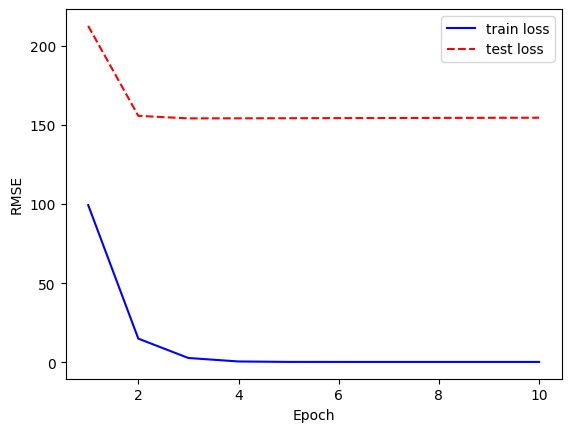

In [38]:
# 超参数
feature_num = 128 # 特征数
learning_rate = 0.01 # 学习率
lbd = 1e-1 # 正则化强度
max_training_step = 10
batch_size = 64 # 批量大小

# 建立模型
model = MF(user_num, item_num, feature_num)
# 训练部分
train_losses, test_losses = train(model, learning_rate, lbd,
    max_training_step, batch_size)

plt.figure()
x = np.arange(max_training_step) + 1
plt.plot(x, train_losses, color='blue', label='train loss')
plt.plot(x, test_losses, color='red', ls='--', label='test loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [53]:
y_test_pred = model.pred(user_test, item_test)
print(y_test_pred[:10]) # 把张量转换为numpy数组
print(y_test[:10])

[128. 128. 128. 128. 128. 128. 128. 128. 128. 128.]
[2 4 4 4 5 2 3 1 4 4]


---

5. 试基于本章的 MF 代码，调试不同的超参数，包括$k$和$\lambda$，关注训练集和测试集的性能指标的改变，根据训练和测试的性能曲线，判定哪些超参数导致过拟合。

数据集大小： 100000
用户数：943，电影数：1682
[215  47  42  19 139 170 320  47  18 156]
[371 109  70 172  70  21 308 158 240  68]


100%|██████████| 37500/37500 [01:01<00:00, 610.12it/s, Epoch=29, Train RMSE=0.9673, Test RMSE=1.0048]


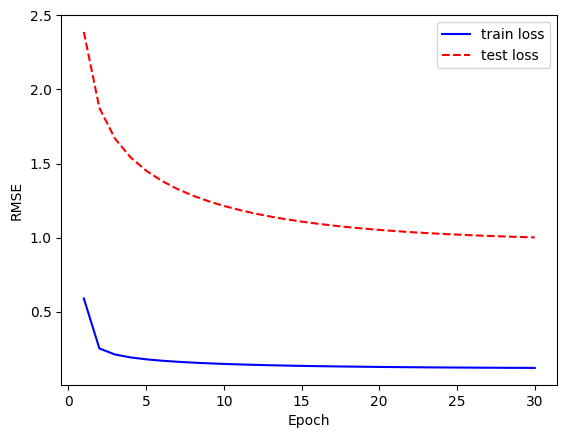

[2.57712395 3.48622005 3.76150216 3.58604004 4.8058418  3.47284112
 3.37246031 4.0917956  3.02605747 3.45742155]
[2 4 4 4 5 2 3 1 4 4]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # 进度条工具

data = np.loadtxt('D:/我的学习/Machine_Learning/动手学机器学习/Hands-on-ML/第7章 双线性模型/movielens_100k.csv', delimiter=',', dtype=int)
print('数据集大小：', len(data))
# 用户和电影都是从1开始编号的，我们将其转化为从0开始
data[:, :2] = data[:, :2] - 1

# 计算用户和电影数量
users = set()
items = set()
for i, j, k in data:
    users.add(i)
    items.add(j)
user_num = len(users)
item_num = len(items)
print(f'用户数：{user_num}，电影数：{item_num}')

# 设置随机种子，划分训练集与测试集
np.random.seed(0)

ratio = 0.8
split = int(len(data) * ratio)
np.random.shuffle(data)
train = data[:split]
test = data[split:]

# 统计训练集中每个用户和电影出现的数量，作为正则化的权重
user_cnt = np.bincount(train[:, 0], minlength=user_num)
item_cnt = np.bincount(train[:, 1], minlength=item_num)
print(user_cnt[:10])
print(item_cnt[:10])

# 用户和电影的编号要作为下标，必须保存为整数
user_train, user_test = train[:, 0], test[:, 0]
item_train, item_test = train[:, 1], test[:, 1]
y_train, y_test = train[:, 2], test[:, 2]

class MF:

    def __init__(self, N, M, d):
        # N是用户数量，M是电影数量，d是特征维度
        # 定义模型参数
        self.user_params = np.ones((N, d))
        self.item_params = np.ones((M, d))

    def pred(self, user_id, item_id):
        # 预测用户user_id对电影item_id的打分
        # 获得用户偏好和电影特征
        user_param = self.user_params[user_id]
        item_param = self.item_params[item_id]
        # 返回预测的评分
        rating_pred = np.sum(user_param * item_param, axis=1)
        return rating_pred

    def update(self, user_grad, item_grad, lr):
        # 根据参数的梯度更新参数
        self.user_params -= lr * user_grad
        self.item_params -= lr * item_grad


def train(model, learning_rate, lbd, max_training_step, batch_size):
    train_losses = []
    test_losses = []
    batch_num = int(np.ceil(len(user_train) / batch_size))
    with tqdm(range(max_training_step * batch_num)) as pbar:
        for epoch in range(max_training_step):
            # 随机梯度下降
            train_rmse = 0
            for i in range(batch_num):
                # 获取当前批量
                st = i * batch_size
                ed = min(len(user_train), st + batch_size)
                user_batch = user_train[st: ed]
                item_batch = item_train[st: ed]
                y_batch = y_train[st: ed]
                # 计算模型预测
                y_pred = model.pred(user_batch, item_batch)
                # 计算梯度
                P = model.user_params
                Q = model.item_params
                errs = y_batch - y_pred
                P_grad = np.zeros_like(P)
                Q_grad = np.zeros_like(Q)
                for user, item, err in zip(user_batch, item_batch, errs):
                    P_grad[user] = P_grad[user] - err * Q[item] + lbd * P[user]
                    Q_grad[item] = Q_grad[item] - err * P[user] + lbd * Q[item]
                model.update(P_grad / len(user_batch), Q_grad / len(user_batch), learning_rate)

                train_rmse += np.mean(errs ** 2)
                # 更新进度条
                pbar.set_postfix({
                    'Epoch': epoch,
                    'Train RMSE': f'{np.sqrt(train_rmse / (i + 1)):.4f}',
                    'Test RMSE': f'{test_losses[-1]:.4f}' if test_losses else None
                })
                pbar.update(1)

            # 计算测试集上的RMSE
            train_rmse = np.sqrt(train_rmse / len(user_train))
            train_losses.append(train_rmse)
            y_test_pred = model.pred(user_test, item_test)
            test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
            test_losses.append(test_rmse)

    return train_losses, test_losses


# 超参数
feature_num = 16 # 特征数
learning_rate = 0.1 # 学习率
lbd = 1e-4 # 正则化强度
max_training_step = 30
batch_size = 64 # 批量大小

# 建立模型
model = MF(user_num, item_num, feature_num)
# 训练部分
train_losses, test_losses = train(model, learning_rate, lbd,
    max_training_step, batch_size)

plt.figure()
x = np.arange(max_training_step) + 1
plt.plot(x, train_losses, color='blue', label='train loss')
plt.plot(x, test_losses, color='red', ls='--', label='test loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

y_test_pred = model.pred(user_test, item_test)
print(y_test_pred[:10]) # 把张量转换为numpy数组
print(y_test[:10])

---

6. 试通过代码实验来验证双线性模型 FM 做回归或分类任务时，其优化目标相对参数是非凸的，也即是，设置不同的参数初始值，使用同样的 SGD 学习算法，最后参数会收敛到不同的位置。

In [20]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

class FactorizationMachine:
    def __init__(self, n_factors, learning_rate=0.0001, n_iterations=5):
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def initialize_parameters(self, n_features):
        self.w0 = np.random.normal()
        self.w = np.random.normal(size=n_features)
        self.V = np.random.normal(size=(n_features, self.n_factors))

    def predict(self, X):
        linear_terms = np.dot(X, self.w) + self.w0
        interaction_terms = 0.5 * np.dot(X.dot(self.V), X.dot(self.V).T - np.dot(X ** 2, self.V ** 2).T)
        return linear_terms + interaction_terms

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.initialize_parameters(n_features)

        for _ in range(self.n_iterations):
            for i in range(n_samples):
                x_i = X[i]
                y_i = y[i]
                prediction = self.predict(x_i)
                error = y_i - prediction

                self.w0 += self.learning_rate * error
                self.w += self.learning_rate * error * x_i

                interaction_grad = np.outer(x_i, (x_i.dot(self.V)))
                interaction_grad_squared = np.outer(np.square(x_i), np.square(self.V).sum(axis=0))
                self.V += self.learning_rate * (error * interaction_grad - interaction_grad_squared)

# Generate synthetic regression data
X_reg, y_reg = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
scaler = StandardScaler()
X_reg = scaler.fit_transform(X_reg)
y_reg = (y_reg - y_reg.mean()) / y_reg.std()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Define FM models with different initial parameters
fm1 = FactorizationMachine(n_factors=5, learning_rate=0.0001, n_iterations=5)
fm2 = FactorizationMachine(n_factors=5, learning_rate=0.0001, n_iterations=5)

# Fit models with the same training data
fm1.fit(X_train, y_train)
fm2.fit(X_train, y_train)

# Predict on testing data
y_pred1 = fm1.predict(X_test)
y_pred2 = fm2.predict(X_test)

# Compute mean squared error, ignoring NaN values
mse1 = np.nanmean((y_test - y_pred1) ** 2)
mse2 = np.nanmean((y_test - y_pred2) ** 2)

print("\nMean Squared Error of FM Model 1:", mse1)
print("Mean Squared Error of FM Model 2:", mse2)



Mean Squared Error of FM Model 1: 7.358669502613401
Mean Squared Error of FM Model 2: 22.492985972076706


优化目标相对于参数是非凸的，是因为在FM（Factorization Machines）模型中，损失函数通常是一个非凸函数。FM模型的目标是最小化损失函数，而损失函数通常由两部分组成：一个是模型预测值与实际值之间的差异，另一个是正则化项（如果有的话）。

在FM模型中，由于存在交互项的双线性部分，导致整个模型的目标函数通常是一个非凸函数。具体来说，双线性部分的参数是相互关联的，当进行参数优化时，优化过程可能会陷入局部最优解，因为目标函数存在多个局部极小值点，使得最终的优化结果取决于初始参数值以及优化算法的选择。

这种非凸性质使得FM模型的参数优化变得复杂，并且可能导致不同的优化结果，即使使用相同的优化算法和超参数设置。因此，为了得到较好的模型性能，通常需要多次运行模型，并选择其中表现最好的结果。